The actual content besides preparatory work (cell 2) and plotting functions (cell 3) start afterwards.

In [1]:
# NECESSARY PYTHON IMPORTS
import numpy as np
from matplotlib import pyplot as plt

from IPython.display import display 
import ipywidgets as widgets 
from ipywidgets import interact, Layout

from copy import copy

class color: # https://stackoverflow.com/a/17303428 : how to use formatting for printing in python
   DARKCYAN, BLUE, RED = '\033[36m', '\033[94m', '\033[91m'
   BOLD, UNDERLINE, END = '\033[1m', '\033[4m',  '\033[0m'

epsilon = np.finfo(float).eps # to take care of binning issues due to machine precision

def hideAxes(h_ax): # hack as RISE.js renders weirdly, create extra axes and then make them invisible
    if not isinstance(h_ax, (list, np.ndarray)):
        h_ax = [h_ax]
    [cur_ax.axis('off') for cur_ax in h_ax]
    
    plt.show()
    
# default size of figures and plot font sizes etc. generated in the notebook, 
# optimized for presentation mode
plt.style.use('seaborn-talk')
FONTSIZE = 24
paramsToSet = {'font.size': FONTSIZE - 2, 'axes.labelsize': FONTSIZE - 5, \
               'xtick.labelsize': FONTSIZE - 6, 'ytick.labelsize': FONTSIZE - 6,\
               'legend.fontsize': 18, 'legend.handlelength': 2,\
               'figure.figsize': [14, 5], \
               'figure.subplot.hspace': 0.5, 'figure.subplot.wspace': 0.5,
               }               
plt.rcParams.update(paramsToSet)

# some widgets for interactive presentation
binSlider = widgets.IntSlider(value=20, min=2, max=20, step=2, description='binsize (ms): '); 
button = widgets.Button(description='Run!', layout=Layout(width='200px')); 
button.style.button_color = 'lightgreen'; 

In [2]:
# refactored code to hide plotting functions during presentation
# is called when needed at the relevant points in the notebook
def plotSpikeTrain(example_spike_train, stimulus_duration):
    h_fig, h_ax = plt.subplots(nrows = 2, ncols = 1, figsize=(6,4), gridspec_kw = {'height_ratios':[10,1]})
    h_ax[0].eventplot(example_spike_train, colors='k', linelengths=0.9, linewidths=1) 

    plt.setp(h_ax[0], yticks = [], ylabel = 'trial #', ylim = [0.5, 1.5], xlabel = 'spike time (s)', \
             xlim =[0, stimulus_duration + 0.05])# focus on stimulus duration]
    [spine.set_visible(False) for key, spine in h_ax[0].spines.items() if key in ['top', 'right']] # hide top and right spine

    hideAxes(h_ax[1]) # clean up
    
def plotBinnedFiringRate(xbin_edges, firing_rate_bins, stimulus_duration): # create a function to reuse later
    h_fig, h_ax = plt.subplots(nrows = 2, ncols = 1, figsize=(6,4), gridspec_kw = {'height_ratios':[10,2.5]})
    h_ax[0].step(xbin_edges[:-1], firing_rate_bins, where = 'post')

    plt.setp(h_ax[0], ylabel = 'rate (Hz)', xlabel = 'time (s)', \
             xlim =[0, stimulus_duration])# focus on stimulus duration]
    
    hideAxes(h_ax[1]) # clean up

def plotGaussianFiringRate(x, gaussian_filter, gauss_x, gauss_kern,\
                          xbin_edges_conv, binsize, firing_rate_smooth):
    h_fig, h_ax = plt.subplots(nrows = 2, ncols = 2, figsize=(14,6),  gridspec_kw = {'height_ratios':[10,1.5]})
    h_ax[0][0].plot(x, gaussian_filter, linewidth=0.5, color='lightgray', label = 'filter')
    h_ax[0][0].plot(gauss_x, gauss_kern, ':', marker='.', color = 'black', label = 'kernel')

    plt.setp(h_ax[0][0], ylabel = 'filter coefficients', title = 'Gaussian filter',\
             xlabel = 'time (s)', xlim =[Tmin, Tmax])

    h_ax[0][0].legend()

    h_ax[0][1].plot(xbin_edges_conv[:-1]+binsize/2, firing_rate_smooth, linewidth=1, color='gray')
    plt.setp(h_ax[0][1], ylabel = 'rate (Hz)', title = 'Estimated firing rate with gaussian window',\
             xlabel = 'time (s)', xlim =[0, stimulus_duration])

    hideAxes(h_ax[1]) # clean up

def plotFiringRateMeth(example_spike_train, xbin_edges, firing_rate_bins,\
                          bin_size,  xbin_edges_conv, firing_rate_smooth,\
                         stimulus_duration):
    h_fig, h_ax = plt.subplots(nrows = 4, ncols = 1, figsize=(10,6), gridspec_kw = {'height_ratios':[3, 3, 3, 2]})
    h_ax[0].eventplot(example_spike_train, colors='k', linelengths=0.9, linewidths=1, label=f"Spike train")
    h_ax[0].set_ylabel('trial #')

    plt.setp(h_ax[0], yticks = [], ylabel = 'spikes', ylim = [0.5, 1.5]) 

    h_ax[1].step(xbin_edges[:-1], firing_rate_bins, where = 'post', label=f"firing rate in bins")
    h_ax[1].set_ylabel('rate (Hz)')

    h_ax[2].plot(xbin_edges_conv[:-1]+binsize/2, firing_rate_smooth, linewidth=1, color='gray', label=f"gaussian window")
    h_ax[2].set_ylabel('rate (Hz)')
    h_ax[2].set_xlabel('time (s)')

    [plt.setp(cur_ax.get_xticklabels(), visible=False) for cur_ax in h_ax[0:2]]
    plt.setp(h_ax[0:3], xlim = [0, stimulus_duration]) # focus on stimulus duration

    [(cur_ax.spines['top'].set_visible(False), cur_ax.spines['right'].set_visible(False)) for cur_ax in h_ax[0:3]]

    lines_labels = [ax.get_legend_handles_labels() for ax in h_fig.axes]
    lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
    #h_ax[2].legend(lines, labels, loc = 'upper left', ncol=3)
    h_fig.legend(lines, labels, loc = 'lower center',ncol = 3)

    hideAxes(h_ax[3]) # clean up


def plotTuningCurve(n_stimuli, firing_rate, stimulus_frequencies, best_frequency):
    h_fig, h_ax = plt.subplots(nrows = 2, ncols = 1, figsize = (10,5),  gridspec_kw = {'height_ratios':[10,1.5]})
    h_ax[0].plot(np.arange(n_stimuli), firing_rate,".-") # plot the tuning curve

    # put a useful label on the abscissa
    xticks = h_ax[0].get_xticks().astype(int)
    xticks = xticks[(xticks >= 0) & (xticks < n_stimuli)]

    plt.setp(h_ax[0], xticks = xticks, xticklabels = (np.round(stimulus_frequencies[xticks]/1000,2)),\
            ylabel ='average firing rate (spikes/s)', xlabel ='frequency (kHz)', xlim = [-0.5, n_stimuli-0.5],\
            title = f"The best frequency of the neuron is {best_frequency} kHz") 

    hideAxes(h_ax[1])
    
def plotSpikeTrainTrials(example_spike_trains, stimulus_duration):
    # is expanded from "plotSpikeTrain" to handle multiple spike trains
    n_trains = len(example_spike_trains)
    if n_trains == 1:
        yticks = []
    else:
        yticks = np.arange(0, n_trains, int(n_trains/10))
    h_fig, h_ax = plt.subplots(nrows = 2, ncols = 1, figsize=(10,5), gridspec_kw = {'height_ratios':[10,1]})
    h_ax[0].eventplot(example_spike_trains, colors='k', linelengths=0.9, linewidths=1) 
    
    plt.setp(h_ax[0], yticks = yticks, yticklabels = yticks + 1, ylabel = 'trial #', ylim = [-0.5, len(example_spike_trains) + .5], xlabel = 'time (s)', \
             xlim =[0, stimulus_duration])# focus on stimulus duration
    [spine.set_visible(False) for key, spine in h_ax[0].spines.items() if key in ['top', 'right']] # hide top and right spine

    hideAxes(h_ax[1]) # clean up
    
def plotLevelTuningCurve(n_stimuli, firing_rate, stimulus_levels, best_level):
    # is just taken from "plotTuningCurve" but changes the annotations
    h_fig, h_ax = plt.subplots(nrows = 2, ncols = 1, figsize = (10,5),  gridspec_kw = {'height_ratios':[10,1.5]})
    h_ax[0].plot(np.arange(n_stimuli), firing_rate,".-") # plot the tuning curve

    # put a useful label on the abscissa
    xticks = h_ax[0].get_xticks().astype(int)
    xticks = xticks[(xticks >= 0) & (xticks < n_stimuli)]

    plt.setp(h_ax[0], xticks = xticks, xticklabels = stimulus_levels[xticks].astype(int),\
            ylabel ='average firing rate (spikes/s)', xlabel ='sound level (dB SPL)', xlim = [-0.5, n_stimuli-0.5],\
            title = f"The best level of the neuron is {best_level} dB SPL") 

    hideAxes(h_ax[1])
    
def plotEventRasterPlot(trains_to_plot, trials_spike_times, n_stimuli, \
                        n_rep, stimulus_frequencies, stimulus_duration):
    h_fig, h_ax = plt.subplots(nrows = 2, ncols = 2, figsize=(8,5), gridspec_kw = {'hspace':0,'height_ratios':[10,1]})
    h_ax[0][0].eventplot(trains_to_plot, colors='k', linelengths=0.9, linewidths=1.2)

    h_ax[0][1].scatter(trials_spike_times[:,3], trials_spike_times[:,2], marker = '.', color='gray')

    # put a useful label on the ordinate
    yticks = np.arange(0,n_rep*n_stimuli,n_rep)

    plt.setp(h_ax[0][1], yticks = yticks[::2], yticklabels = np.round(stimulus_frequencies[(yticks[::2] / n_rep).astype(int)]/1000, 2),\
            ylabel = 'frequency [kHz]', xlabel = 'time (s)')
    plt.setp(h_ax[0][0], ylabel = 'trial #', xlabel = 'time (s)')
    plt.setp(h_ax[0], xlim = [0, stimulus_duration]) # focus on stimulus duration

    plt.tight_layout()

    hideAxes(h_ax[1])
    
def plotLevelEventPlot(trains_to_plot, trials_spike_times, n_stimuli, \
                        n_rep, stimulus_levels, stimulus_duration):
    
    h_fig, h_ax = plt.subplots(nrows = 2, ncols = 1, figsize=(6,6), gridspec_kw = {'hspace':0,'height_ratios':[10,1]})
    h_ax[0].eventplot(trains_to_plot, colors='k', linelengths = 2, linewidths=1.5)

    # put a useful label on the ordinate
    yticks = np.arange(0,n_rep*n_stimuli,n_rep).astype(int)

    plt.setp(h_ax[0], yticks = yticks[::2], yticklabels = stimulus_levels[(yticks[::2] / n_rep).astype(int)].astype(int),\
            ylabel = 'sound level (dB SPL)', xlabel = 'time (s)', xlim = [0, stimulus_duration]) # focus on stimulus duration

    hideAxes(h_ax[1]) 
    
def plotPSTH(xbin_edges, firing_rate_bins, stimulus_duration): # create a function to reuse later
    h_fig, h_ax = plt.subplots(nrows = 2, ncols = 1, figsize=(10,5), gridspec_kw = {'height_ratios':[10,2.5]})
    h_ax[0].step(xbin_edges[:-1], firing_rate_bins, where = 'post')

    plt.setp(h_ax[0], ylabel = 'firing rate (spk/s)', xlabel = 'time (s)', \
             xlim =[0, stimulus_duration],\
            title = 'Peri-stimulus time histogram')
    
    hideAxes(h_ax[1]) # clean up   

# <center>Spike train analysis using Python</center>
<br/>
<br/>
<img src="images/spike_train.gif" alt="cortical extracellular recording M8T_09-02-10_001" width=65% style="margin-left:auto; margin-right:auto">  
<center><span style="color:LightSlateGray">Dr. Marcus Jeschke</span></center>
<center><span style="color:LightSlateGray">Deutsches Primatenzentrum/Universitätsmedizin Göttingen</span></center>
<center><span style="color:LightSlateGray">Cognitive Hearing in Primates lab/Institut für Auditorische Neurowissenschaften</span></center>
<br/>

Lehrprobe - Oldenburg W2-Neurobiologie des Hörens; 2.11.2021 
<br/>
GitHub repository: https://github.com/JeschkeM/LehrprobeUOL
<br/>
The notebook can be viewed via https://nbviewer.org/
<br/>

#### Intro: Reminder - What are spike trains?
- sequence of action potentials (or spikes) of neurons recorded electrically (via: pipettes/electrodes/electrode arrays) or optically (2PM)
<h5> From raw data to neuronal spike trains</h5>
<img src="images/fromRawDataToSpikeTrain.png" alt="From raw data recorded with metal electrodes to neuronal spike trains" width=80% style="margin-left:auto; margin-right:auto">



#### The "central task" for the analysis of spike trains

- How does an animal/human make sense of the incoming spike trains to figure something out about the world in order to act?
- What properties of the spike trains tell us something about the world (i.e. stimuli)? Are some of them better or worse?

<img src="images/StimuliToNeuron.png" width=40% style="margin-left:auto; margin-right:auto">
<br/>
<center><strong> The task is to understand something about the neural code. </strong></center>


## What will you learn today?
1. Firing rates
2. Tuning curves
3. Peri-stimulus time histogram


## Disclaimer

This lecture is prepared as an interactive Jupyter notebook.

GitHub repository: https://github.com/JeschkeM/LehrprobeUOL
<br/>
The notebook can be viewed via https://nbviewer.org/
<br/>
Working along requires a Jupyter http://jupyter.org or Anaconda https://www.anaconda.com/products/individual installation.

The Python code shown is not a 'best practice' example of how to write Python code and functions. Rather, for readability and conciseness I have not created proper doc strings, error handling etc. I also wrote plotting functions that I will not go through as this is not in the scope of the notebook.

The code also tries to avoid using external libraries (requires *```numpy```* and *```matplotlib```*) as much as possible and instead generates code from first principles for illustrating concepts.

Notable libraries include:
- https://briansimulator.org/getting-started/<div style="float:right;"><img src="images/brian_logo_big.webp" width=120 style="margin-left:auto; margin-right:auto"></div>
<br/>
<br/>
- https://elephant.readthedocs.io/en/latest/<div style="float:right;"><img src="images/elephant_logo_sidebar.png" width=120 style="margin-left:auto; margin-right:auto"></div>
<br/>
<br/>
- https://pythonhosted.org/neuronpy/index.html 
<br/>
&#8205; 

## 1. Firing rates

Spike train: $\{ t(i) \} = \{t_{1}, t_{2}, ... , t_{n}\}$ stands for a number of spikes $n$ occuring at times $t(i)$ 

<img src="images/fromRawDataToSpikeTrain.png" alt="From raw data recorded with metal electrodes to neuronal spike trains" width=65% style="margin-left:auto; margin-right:auto">

Could like e.g. like this:

*```
[0.1411, 0.1789, 0.5409, 0.5922, 0.7114, 0.9662, 1.2608, 1.3203, 1.3683, 
1.8849, 1.9083, 1.9509, 2.4425, 2.9103, 2.9317, 3.0405, 4.2415, 4.3468]```*
 
or in a binary format (binned spike train): *```00000000110000000000000000001010000010000000000001```*
<br/>
&#8205; 

Let us load our first spike train and look at it:

*```
trials_spike_times = np.loadtxt('data' + '/' + 'M13W1671_trials_spike_times.txt', delimiter = ',',skiprows = 1) 
```*


Stimulus | Repetition | TrialNumber | Spike time [s]
--- | --- | --- | ---
18. | 1.  | 119. | **-0.212595** 
18. | 1.  | 119. |  **-0.069675**  
18. | 1.  | 119. |  **0.299101**
...
3.  | 7.  | 21. | **0.237816**   
3.  | 7.  | 21. |**0.271716** 
3.  | 7.  | 21. | **0.541293**  

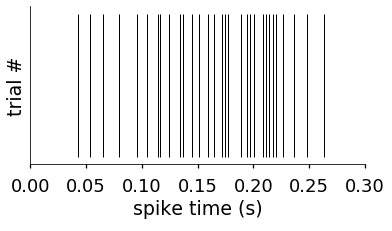

In [3]:
# load data from a pure tone stimulation experiment, data recorded from 
# the auditory thalamus of an awake monkey
example_file = 'data' + '/' + 'M13W1671_trials_spike_times.txt'
trials_spike_times = np.loadtxt(example_file,\
                                delimiter = ',',skiprows = 1) 

# general parameters
stimulus_duration = 0.25
example_trial     = 95

# numpy's UNIQUE function retrieves unique entries in an array
un_trials = np.unique(trials_spike_times[:,2]) # unique trials

# example trial containing spike train aligned to stimulus onset 
example_spike_train = trials_spike_times[trials_spike_times[:,2]\
                                         == un_trials[example_trial],3]

# Plotting (makes use of matplotlib's EVENTPLOT function)
plotSpikeTrain(example_spike_train, stimulus_duration)

### How to calculate a firing rate from the spike train?

We could just count the spikes while the stimulus was presented and normalize by the stimulus duration to get the:

<strong>Spike count rate</strong>: $$r = \frac{n}{T}$$

In [4]:
# calculate spike count after stimulus onset defined as 0 s 
# and before or at the stimulus duration
spike_count_rate = sum((example_spike_train > 0 ) & \
                       (example_spike_train <= stimulus_duration))\
                        /stimulus_duration

print(f"spike count rate of the trial: {spike_count_rate} Hz")
print("\n") 

spike count rate of the trial: 120.0 Hz




Clearly, there seems to be more dynamics than what we capture with a single number. How do we arrive at a time varying rate?

- we could bin the spike trains into time windows of length $\Delta t$ and count the spikes there

<strong>Time dependent firing rate</strong>: $$r(t) = \frac{n(t; t + \Delta t)}{\Delta t}$$

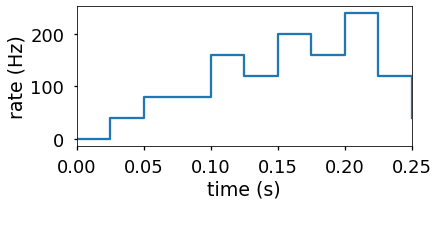

In [5]:
# time varying firing rate by counting spikes in bins
binsize = 0.025 # 25 ms window length/bins

# create array containing bin edges using numpy's ARANGE function
xbin_edges = np.arange(0, stimulus_duration+binsize*2, binsize) # create array containing bin edges
# numpy's HISTOGRAM counts the number of occurences in a bin
firing_rate_bins = np.histogram(example_spike_train, \
                                bins = xbin_edges)[0]\
                /binsize # normalize by binsize
                                                                                
# Plotting  (makes use of matplotlib's STEP function)
plotBinnedFiringRate(xbin_edges, firing_rate_bins, stimulus_duration)

### What is a 'good' bin size? What happens if we change it?

In [6]:
# Widget for the spike rate calculation
display(binSlider); # binsize to use for calculation
display(button); # button to change spike rate

def on_button_clicked(sender): 
    binsize = binSlider.value/1000 # gather rate from slider
    
    # calculation
    xbin_edges = np.arange(0, stimulus_duration+binsize*2, binsize) # create array containing bin edges
    firing_rate_bins = np.histogram(example_spike_train, \
                                    bins = xbin_edges)[0]/binsize
    
    plotBinnedFiringRate(xbin_edges, firing_rate_bins, stimulus_duration) # plotting

# run the calculation on click
button.on_click(on_button_clicked)

IntSlider(value=20, description='binsize (ms): ', max=20, min=2, step=2)

Button(description='Run!', layout=Layout(width='200px'), style=ButtonStyle(button_color='lightgreen'))

### How can we get a smoothly varying firing rate $r(t)$?

Use a window function to step through the spike train and generate a continuous function.

###### Gaussian window


Gaussian function: $ {g}(x) = \frac{1}{\sigma\sqrt{2\pi}} \operatorname{exp}\left({{{ -\frac{1}{2} \frac{\left( {x - \mu } \right)^2}{\sigma^2} }}}\right) $
<br/>
We can create a binary spike train and convolve it with the gaussian window to estimate the firing rate over time.

In [7]:
def gaussian_kernel(sigma, mu, bandwidth, dt, Tmin, Tmax):
    # time frame in which to calculate a gaussian
    x = np.arange(Tmin, Tmax+dt, dt) 
    
    # gaussian function
    x1 = sigma * np.sqrt(2 * np.pi) 
    x2 = np.exp(-(x - mu)**2/(2 * sigma**2))
    gaussian_filter = (1/x1)*x2
    
    # what time frame to use for the kernel itself
    bandwidth_x = np.all((x > -bandwidth/2-epsilon,\
                          x <= bandwidth/2+epsilon),0)
    gaussian_kernel = gaussian_filter[bandwidth_x] 
    
    return gaussian_kernel, x[bandwidth_x]

def convSpikeTrainWindow(spike_train_binary, window):
    # convolution with np.convolve results in a longer array 
    # than the stimulus
    convolution_full = np.convolve(spike_train_binary, window)

    window_len = len(window)
    trim_len   = int(window_len/2)
    # trim the convolved signal to signal 
    firing_rate_smooth = convolution_full[trim_len:-trim_len:]
    
    return firing_rate_smooth

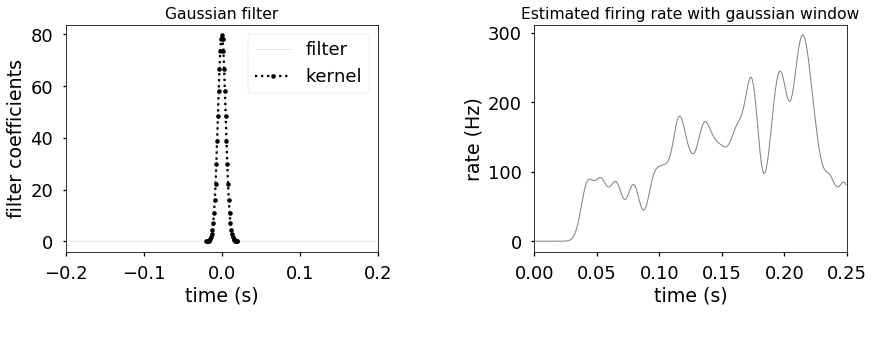

In [8]:
# Variables for the gaussian window
sigma = 0.005
bandwidth = 0.04
mu = 0
Tmin, Tmax = -0.20, 0.20
binsize = 0.001 # binsize for the gaussian window and 
# to create the binary spike train

# use the spike count method from above to generate a binary spike train
xbin_edges_conv = np.arange(0, stimulus_duration+binsize, binsize)
spike_train_binary = np.histogram(example_spike_train,\
                                  bins = xbin_edges_conv)[0]

# gaussian window
gaussian_filter, x = gaussian_kernel(sigma, mu, Tmax*2, binsize, Tmin, Tmax)
gauss_kern, gauss_x = gaussian_kernel(sigma, mu, bandwidth, binsize, Tmin, Tmax)

# calculate the convolution of the spike train and our gaussian window
firing_rate_smooth = convSpikeTrainWindow(spike_train_binary,\
                                          gauss_kern)
 
# Plotting
plotGaussianFiringRate(x, gaussian_filter, gauss_x, gauss_kern,\
                    xbin_edges_conv, binsize, firing_rate_smooth)

Let us put our spike train and various methods to calculate a time varying firing rate together.

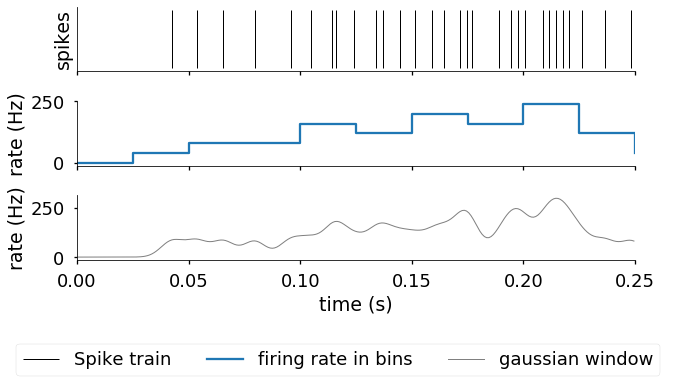

In [9]:
# Plotting
plotFiringRateMeth(example_spike_train, xbin_edges, firing_rate_bins,\
                    binsize,  xbin_edges_conv, firing_rate_smooth,\
                    stimulus_duration)

## 2. Tuning curves

A tuning curve describes neuronal responses in relation to stimulus properties such as frequency, level etc.<br/>
Tuning curves are usually based on the presentation of multiple trials of a given stimulus. 

<img src="images/M13W1671_Raster.png" width=48% style="margin-left:auto; margin-right:auto">

Then we can expand the <strong>spike count rate</strong>: $r = n/T$ 
to multiple trials to get the <strong>average firing rate:</strong> $\langle r \rangle = \frac{\langle n \rangle}{T}$, with $\langle \cdot \rangle$ denoting the average.

The tuning curve is then the average firing rate as a function of the stimulus or stimulus property: $\langle r \rangle = f(s)$

In [10]:
def avg_firing_rate(spike_counts, duration):
        return np.mean(spike_counts)/duration

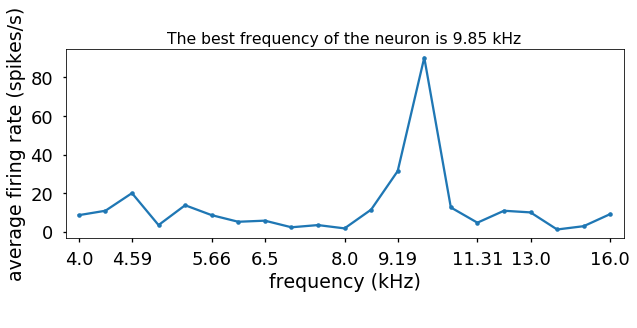

In [11]:
# load the data of a frequency tuning experiment from a 
# thalamic neuron of an awake marmoset
example_stim_file = 'data/M13W1671_stimuli.txt'
example_data_file = 'data/M13W1671_trials_spike_times.txt'
stimulus_frequencies = np.loadtxt(example_stim_file, skiprows = 1) 
trials_spike_times   = np.loadtxt(example_data_file, delimiter = ',',skiprows = 1) 

# general parameters
stimulus_duration = 0.25
n_stimuli = len(stimulus_frequencies) # or unique entries in the first column of trials_spike_times
n_rep     = max(trials_spike_times[:,1])

# return unique rows consisting of a stimulus index and trial ID
un_trials = np.unique(trials_spike_times[:,[0,2]], axis = 0) 
               
# collect spike counts per trial during stimulus presentation
trial_spike_counts = np.zeros(len(un_trials))
trains_to_plot = []
for idxTrial, curTrial in enumerate(un_trials[:,1]):
    cur_trial_spike_times = trials_spike_times[\
                                trials_spike_times[:,2] == curTrial,3]
    # count spikes of the current trial during the stimulus
    trial_spike_counts[idxTrial] = sum((cur_trial_spike_times > 0) &\
                        (cur_trial_spike_times <= stimulus_duration))
    
    trains_to_plot.append(trials_spike_times[\
                trials_spike_times[:,2] == curTrial,3]) # keep a reference for plotting

# calculate the average firing rate per stimulus
firing_rate = np.zeros(len(stimulus_frequencies))
for idxStim, curStim in enumerate(np.unique(un_trials[:,0])):
    firing_rate[idxStim] = avg_firing_rate(\
                trial_spike_counts[un_trials[:,0] == curStim],\
                stimulus_duration)    
    
# identify the peak firing rate to get the stimulus that drives the neuron best   
best_frequency = np.round(stimulus_frequencies[\
                                np.argmax(firing_rate)]/1000,2)
    
# Plotting
plotTuningCurve(n_stimuli, firing_rate, \
                stimulus_frequencies, best_frequency)

Let us also create a raster plot to check our calculations:

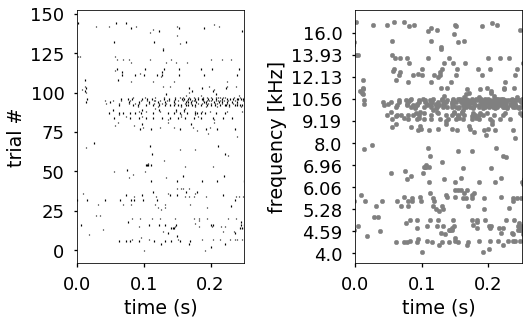

In [12]:
# Plotting (makes use of matplotlib's EVENTPLOT and SCATTER function)
plotEventRasterPlot(trains_to_plot, trials_spike_times, n_stimuli, \
                    n_rep, stimulus_frequencies, stimulus_duration)

## 3. Peri-stimulus time histogram (PSTH)

To derive the idea of a peri-stimulus time histogram we will look at an example from a pure tone stimulation experiment while recording from an auditory nerve fiber.

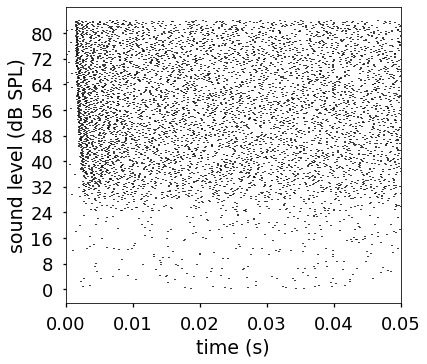

In [13]:
# load the data of a pure tone sound level experiment from an 
# auditory nerve fiber of a gerbil
example_stim_file = 'data/AH_G_ANF_stimuli.txt'
example_data_file = 'data/AH_G_ANF_trials_spike_times.txt'
stimulus_levels   = np.loadtxt(example_stim_file, skiprows = 1) 
trials_spike_times= np.loadtxt(example_data_file, delimiter = ',',skiprows = 1) 

# general parameters
stimulus_duration = 0.05
n_stimuli = len(stimulus_levels) # or unique entries in the first column of trials_spike_times
n_rep     = int(max(trials_spike_times[:,1]))
              
# collect spike counts per trial during stimulus presentation
trial_spike_counts = np.zeros(n_stimuli * n_rep)
trains_to_plot = []
for curTrial in range(n_stimuli * n_rep):
    cur_trial_spike_times = trials_spike_times[\
                    trials_spike_times[:,2] == curTrial + 1,3]
    # count spikes of the current trial during the stimulus
    trial_spike_counts[curTrial] = sum((cur_trial_spike_times > 0) &\
                            (cur_trial_spike_times <= stimulus_duration))
    # keep a reference of the trial spike train for plotting
    trains_to_plot.append(trials_spike_times[
                            trials_spike_times[:,2] == curTrial,3]) 
    
# Plotting (makes use of matplotlib's EVENTPLOT function)
plotLevelEventPlot(trains_to_plot, trials_spike_times, n_stimuli, \
                        n_rep, stimulus_levels, stimulus_duration)

As further practice let us look at the tuning curve for sound level.

The best level of the neuron is 72 dB SPL


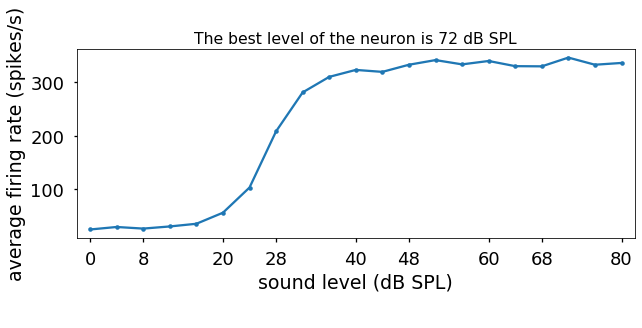

In [14]:
# calculate the average firing rate per stimulus
firing_rate = np.zeros(n_stimuli)
for curStim in range(n_stimuli):
    firing_rate[curStim] = avg_firing_rate(\
        trial_spike_counts[curStim*n_rep : curStim*n_rep + n_rep],\
        stimulus_duration) 
    
# identify the peak firing rate to get the stimulus that drives the neuron best   
best_level = stimulus_levels[np.argmax(firing_rate)].astype(int)
print(f"The {color.BOLD}best level{color.END} of the neuron is {best_level} dB SPL")

# Plotting
plotLevelTuningCurve(n_stimuli, firing_rate,\
                     stimulus_levels, best_level)

Let us look more closely at the different repetitions of the same stimulus. We are going to look at 20 repetitions of the loudest stimulus (80 dB SPL) in our dataset.

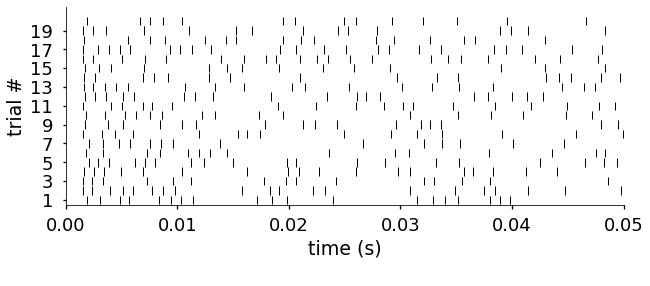

In [15]:
# PLOT 20 trials of the last stimulus (loudest)
n_trials_to_plot = 20
plotSpikeTrainTrials(trains_to_plot[-n_trials_to_plot::], stimulus_duration)

So we could expand our idea of a <strong>time dependent firing rate</strong> $r(t) = {n(t; t + \Delta t)}/{\Delta t}$

to a spike density in small time windows $\Delta t$ by averaging over trials $K$.

<strong>Spike density:</strong> $$\rho(t)={1\over\Delta t}{n_{K}(t;t+\Delta t)\over K}$$

also results in a time dependent firing rate.

The <strong>peri-stimulus time histogram</strong> is the spike density linked to the stimulus onset.

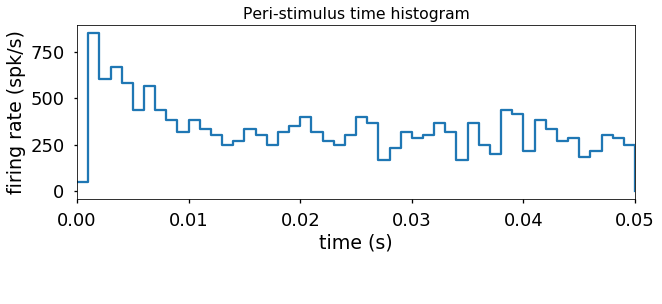

In [16]:
# time varying firing rate by counting spikes in bins over trials
binsize = 0.001 # 1 ms window length/bins

# find all spikes for the loudest stimulus and during stimulus duration
stim_spikes = trials_spike_times[\
                (trials_spike_times[:,0] == n_stimuli) &\
                (trials_spike_times[:,3] > 0) &\
                (trials_spike_times[:,3] <= stimulus_duration),3]

# create array containing bin edges using numpy's ARANGE function
xbin_edges = np.arange(0, stimulus_duration+binsize*2, binsize) # create array containing bin edges
# numpy's HISTOGRAM counts the number of occurences in a bin
spike_density = np.histogram(stim_spikes, bins = xbin_edges)[0]\
                /(binsize * n_rep) # normalize by binsize and number of stimulus repetitions

# PLOTTING (reuse the plotting function for the binned firing rate)
plotPSTH(xbin_edges, spike_density, stimulus_duration)

The peri-stimulus time histogram therefore gives an estimate of the instantaneous firing rate.


### Is all of this relevant for today's neuroscience?

With these tools in hand we can now perform a lot of common data analysis tasks in the neurosciences.
<img src="images/PSTH_Oldenburg.png"  alt="PSTH" width = 40% style="margin-left:auto; margin-right:auto">

<div style="text-align: right;font-size:10pt">top: from Ashida et al. 2019 PLoS Comp.Biol. Fig. 1.<br/>bottom: Gothner et al. 2021 Cereb. Cortex. Fig. 1
</div>

## Summary - Spike train analysis using Python

<table>
   <tr>
    <td>Firing rates</td>
    <td>Tuning curves</td>   
    <td>Peri-stimulus time histograms</td> 
   </tr> 
   <tr>
    <td> <img src="images/firingRate.png"  alt="firing rate" width = 80%></td>
    <td><img src="images/tuningCurve_M13W1671.png" alt="tuning curve" width = 80%></td>  
    <td><img src="images/PSTH_AH_G_ANF.png" alt="PSTH" width = 80%></td> 
   </tr> 
</table>


Github repository of the lecture: https://github.com/JeschkeM/LehrprobeUOL

Bonus: can you spot the bug in the firing rate evaluation code? 2nd bonus: can you fix it?


Email me: mjeschke@dpz.eu